In [1]:
import os
import json 

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from accelerate import Accelerator
from diffusers import StableDiffusionPipeline
from diffusers import DDIMScheduler, DDPMPipeline
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-09 17:52:26.216920: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 17:52:26.229390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:173

In [12]:
def to_kanji_caption(definition):
    return f"Japanese calligraphy character meaning: '{definition}'. Character should be colored black on a white background."

In [3]:
torch.cuda.empty_cache()

if torch.cuda.is_available():
    torch.cuda.synchronize()
    current_device = torch.cuda.current_device()
    torch.cuda.empty_cache()

    print(f"Memory allocated: {torch.cuda.memory_allocated(current_device) / 1024**2:.2f} MB")
    print(f"Memory cached: {torch.cuda.memory_reserved(current_device) / 1024**2:.2f} MB")

Memory allocated: 0.00 MB
Memory cached: 0.00 MB


In [4]:
output_dir = 'finetuned_kanji_checkpoints'
img_pipeline = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path = output_dir,
)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.97it/s]


In [16]:
import matplotlib.pyplot as plt

def generate_kanji_samples(pipeline, kanji_prompts, device):
   pipeline = pipeline.to(device)
   images = []
   
   with torch.no_grad():
       for prompt in kanji_prompts:
           image = pipeline(to_kanji_caption(prompt), num_inference_steps=50).images[0]
           images.append(image)
   
   return display_kanji_grids(images, kanji_prompts)

def display_kanji_grids(images, prompts):
   n = len(images)
   rows = (n + 3) // 4
   
   figs = []
   for grid in range(rows):
       start_idx = grid * 4
       end_idx = min(start_idx + 4, n)
       grid_images = images[start_idx:end_idx]
       grid_prompts = prompts[start_idx:end_idx]
       
       fig, axes = plt.subplots(2, 2, figsize=(12, 12))
       for ax in axes.flat:
           ax.axis('off')
           
       for idx, (img, prompt) in enumerate(zip(grid_images, grid_prompts)):
           row, col = divmod(idx, 2)
           axes[row, col].imshow(img)
           axes[row, col].set_title(f"Kanji: {prompt}", fontsize=12)
           
       plt.tight_layout()
       figs.append(fig)
   
   return figs

100%|██████████| 50/50 [00:08<00:00,  5.98it/s]


[<Figure size 864x864 with 4 Axes>,
 <Figure size 864x864 with 4 Axes>,
 <Figure size 864x864 with 4 Axes>,
 <Figure size 864x864 with 4 Axes>]

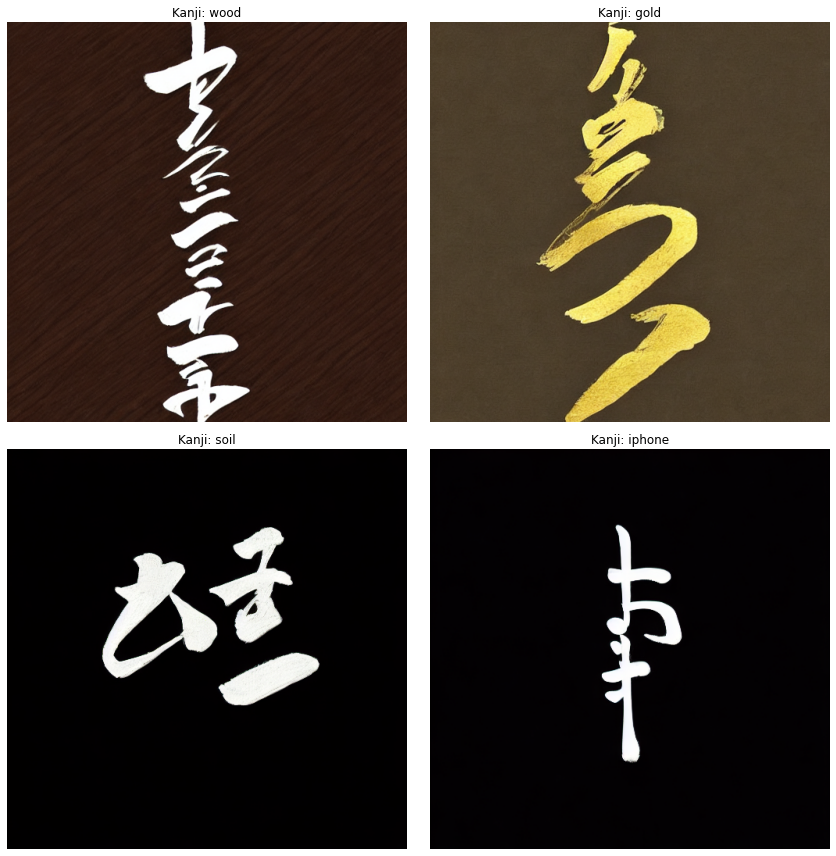

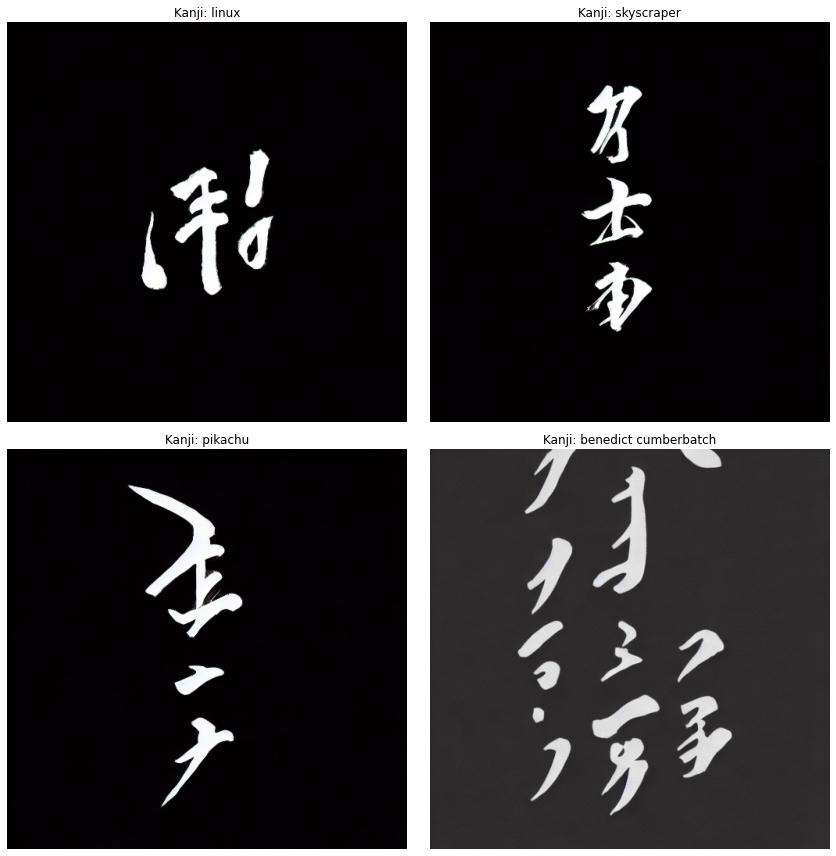

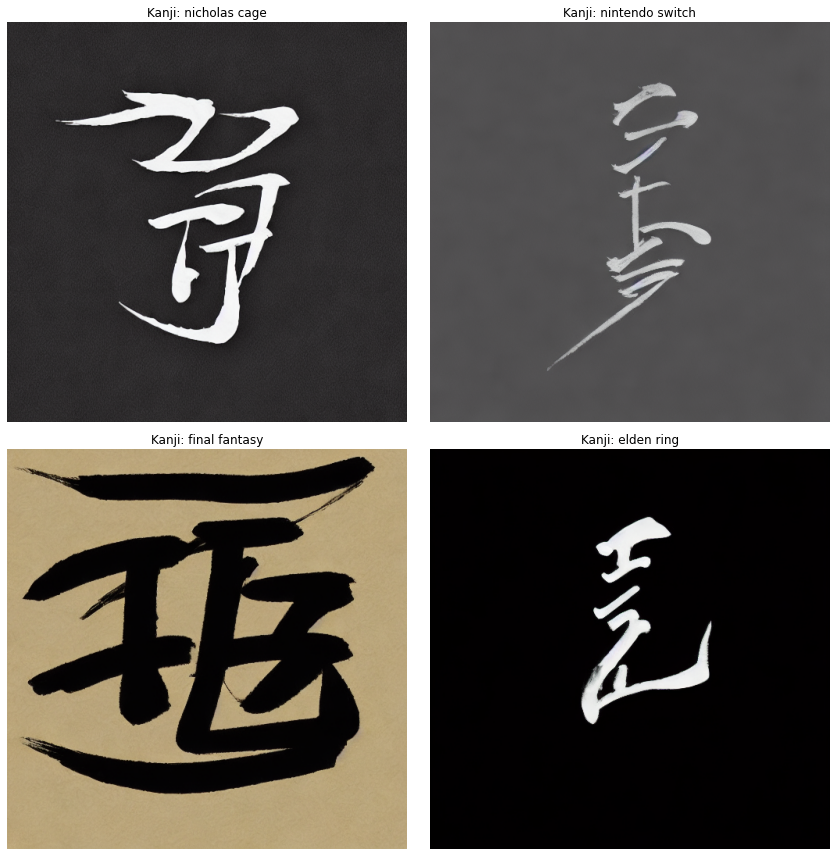

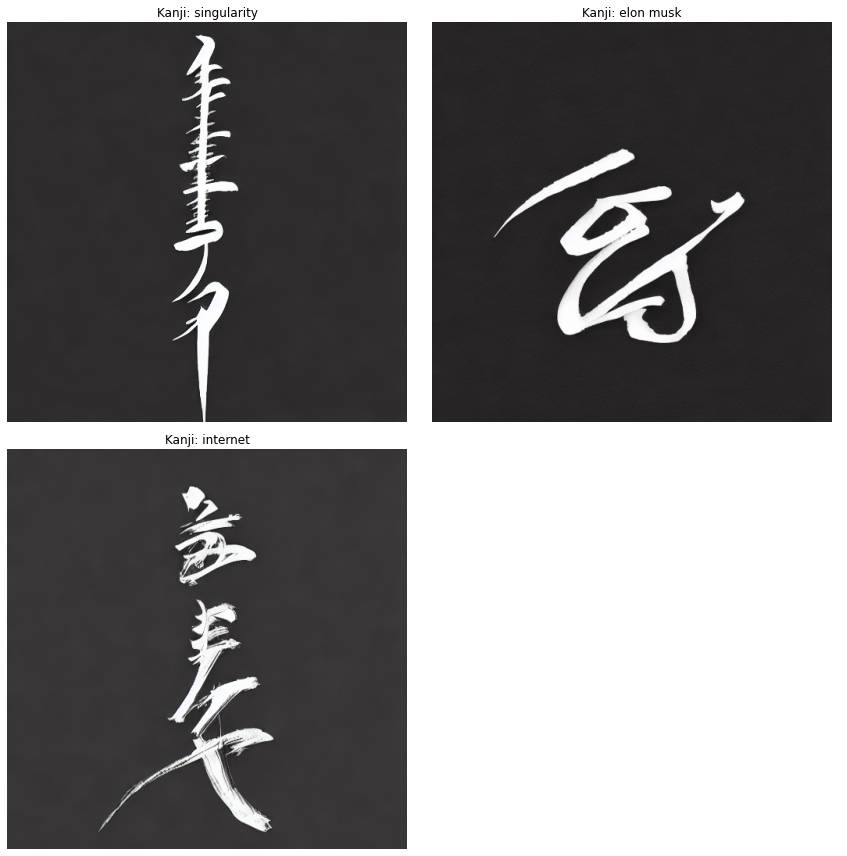

In [17]:
prompts = [
    'wood', 
    'gold', 
    'soil', 
    'iphone',
    'linux',
    'skyscraper',
    'pikachu',
    'benedict cumberbatch',
    'nicholas cage',
    'nintendo switch',
    'final fantasy',
    'elden ring',
    'singularity',
    'elon musk',
    'internet'
]

generate_kanji_samples(img_pipeline, prompts, 'cuda')